In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import lightgbm as lgb
import warnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

In [2]:
# 各種設定
DICT_DTYPE = {'LOAN_ID': 'str', 'IMAGE_ID': 'str'}
# os.chdir('/work/')
os.chdir('/Users/kinoshitashouhei/Desktop/competitions/05_Prob_Space/Kiva/')

In [3]:
# 自作関数のインポート
from functions.common import *
from functions import preprocessing

In [4]:
# データの読み込み
df_train = pd.read_csv('data/train.csv', dtype=DICT_DTYPE)
df_test = pd.read_csv('data/test.csv', dtype=DICT_DTYPE)

In [5]:
df_train.head()

,LOAN_ID,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,LOAN_AMOUNT,IMAGE_ID,ACTIVITY_NAME,SECTOR_NAME,LOAN_USE,COUNTRY_CODE,COUNTRY_NAME,TOWN_NAME,CURRENCY_POLICY,CURRENCY_EXCHANGE_COVERAGE_RATE,CURRENCY,TAGS,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL
0,1733169,English,Teodora is a 50-year-old married woman from th...,Teodora is a 50-year-old married woman from th...,100,3115271,Weaving,Arts,"to purchase materials like nipa palm, bamboo ...",PH,Philippines,"Maribojoc, Bohol",shared,0.1,PHP,#Elderly,monthly,field_partner
1,1546998,English,Diego is 32 years old and lives in the municip...,Diego is 32 years old and lives in the municip...,1350,2870403,Barber Shop,Services,"to buy two hair clippers, a new barber chair, ...",CO,Colombia,Apartadó,shared,0.1,COP,"user_favorite, user_favorite",monthly,field_partner
2,1808517,Spanish,"Osman, es un joven de 27 años de edad, soltero...","Osman is a young man, 27 years old, single, an...",225,3215705,Farming,Agriculture,to purchase sacks of fertilizers to care for a...,HN,Honduras,"Nueva Frontera, Santa Barbara.",shared,0.1,HNL,NaN,bullet,field_partner
3,1452940,English,"His name is Nino, 31 years old, married to Che...","His name is Nino, 31 years old, married to Che...",350,2745031,Motorcycle Transport,Transportation,"to pay for fuel, tires and change oil for his ...",PH,Philippines,"Silang, Cavite",shared,0.1,PHP,user_favorite,monthly,field_partner
4,1778420,English,"Pictured above is Teresa, often described as a...","Pictured above is Teresa, often described as a...",625,3083800,Farming,Agriculture,to purchase hybrid seeds and fertilizer to imp...,KE,Kenya,Mumias,shared,0.1,KES,"#Eco-friendly, #Sustainable Ag, #Parent, #Elde...",bullet,field_partner


In [6]:
df_test.head()

,LOAN_ID,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,IMAGE_ID,ACTIVITY_NAME,SECTOR_NAME,LOAN_USE,COUNTRY_CODE,COUNTRY_NAME,TOWN_NAME,CURRENCY_POLICY,CURRENCY_EXCHANGE_COVERAGE_RATE,CURRENCY,TAGS,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL
0,2041445,English,Marcela is 69 years old and married with ten c...,Marcela is 69 years old and married with ten c...,4051101,General Store,Retail,to buy items to sell like canned goods and per...,PH,Philippines,"Cauayan, Negros Occidental",standard,NaN,PHP,NaN,monthly,field_partner
1,1944435,English,Roselia is 48 years old and has five children....,Roselia is 48 years old and has five children....,3410523,Pigs,Agriculture,to buy feeds and other supplies to raise her pig,PH,Philippines,"Guihulngan, Negros Oriental",standard,NaN,PHP,"#Animals, #Repeat Borrower, #Schooling, #Woman...",monthly,field_partner
2,2083354,English,"Ma. Marebil is a single woman, 40 years old wi...","Ma. Marebil is a single woman, 40 years old wi...",4146690,Clothing Sales,Clothing,to buy additional stock of clothes and dresses...,PH,Philippines,"Santa Barbara, Iloilo",standard,NaN,PHP,"#Parent, #Single Parent, #Woman-Owned Business",monthly,field_partner
3,1993565,English,"Good day, lenders! Meet one of KBMI’s clients,...","Good day, lenders! Meet one of KBMI’s clients,...",3945982,Food,Food,to buy more foods to grow her business.,ID,Indonesia,Pandeglang,shared,0.1,IDR,"#Woman-Owned Business, #Schooling, #Elderly, #...",monthly,field_partner
4,2064272,English,Rosemarie is a married woman with two children...,Rosemarie is a married woman with two children...,4114040,Food,Food,to buy ingredients for her food production bus...,PH,Philippines,Sogod Cebu,standard,NaN,PHP,NaN,monthly,field_partner


In [7]:
# データサイズの確認
print(f'df_train size : {df_train.shape}')
print(f'df_test size : {df_test.shape}')

df_train size : (91333, 18)
df_test size : (91822, 17)


In [8]:
# データの型の確認
print(f'df_train dtypes\n{df_train.dtypes}')
print('='*50)
print(f'df_test dtypes\n{df_test.dtypes}')

df_train dtypes
LOAN_ID                             object
ORIGINAL_LANGUAGE                   object
DESCRIPTION                         object
DESCRIPTION_TRANSLATED              object
LOAN_AMOUNT                          int64
IMAGE_ID                            object
ACTIVITY_NAME                       object
SECTOR_NAME                         object
LOAN_USE                            object
COUNTRY_CODE                        object
COUNTRY_NAME                        object
TOWN_NAME                           object
CURRENCY_POLICY                     object
CURRENCY_EXCHANGE_COVERAGE_RATE    float64
CURRENCY                            object
TAGS                                object
REPAYMENT_INTERVAL                  object
DISTRIBUTION_MODEL                  object
dtype: object
df_test dtypes
LOAN_ID                             object
ORIGINAL_LANGUAGE                   object
DESCRIPTION                         object
DESCRIPTION_TRANSLATED              object
IMAGE_ID 

In [20]:
# 欠損数の確認
pd.concat([pd.DataFrame(df_train.isnull().sum(), columns=['n_null_train']),
           pd.DataFrame(df_test.isnull().sum(), columns=['n_null_test'])],
           axis=1)

,n_null_train,n_null_test
LOAN_ID,0,0.0
ORIGINAL_LANGUAGE,0,0.0
DESCRIPTION,0,0.0
DESCRIPTION_TRANSLATED,1,0.0
LOAN_AMOUNT,0,NaN
IMAGE_ID,0,0.0
ACTIVITY_NAME,0,0.0
SECTOR_NAME,0,0.0
LOAN_USE,0,0.0
COUNTRY_CODE,0,0.0


#### 使用言語
 - 5ヶ国語あり、英語が最も多い
 - 学習データとテストデータの分布に違いは見られない

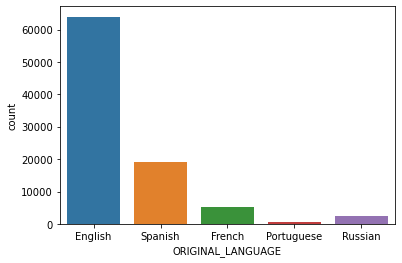

In [15]:
# 訓練データ
sns.countplot(df_train[COL_ORIGINAL_LANGUAGE])
plt.show()

In [27]:
pd.DataFrame(df_train[COL_ORIGINAL_LANGUAGE].value_counts())

,ORIGINAL_LANGUAGE
English,63938
Spanish,18966
French,5176
Russian,2530
Portuguese,723


In [23]:
df_train.groupby(COL_ORIGINAL_LANGUAGE).agg({COL_LOAN_AMOUNT: ['min', 'max', 'median', 'mean']})

LOAN_AMOUNT                           
                          min    max median         mean
ORIGINAL_LANGUAGE                                       
English                    25  10000  375.0   592.614330
French                     50  10000  350.0  1020.749614
Portuguese                100   4425  650.0  1124.827109
Russian                    25   3675  675.0   890.424901
Spanish                    50   9850  800.0  1116.600759

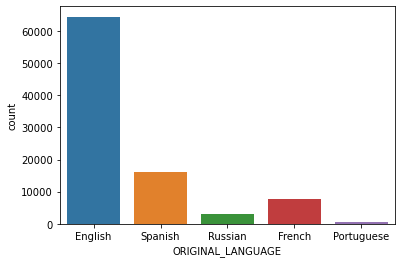

In [16]:
# テストデータ
sns.countplot(df_test[COL_ORIGINAL_LANGUAGE])
plt.show()

In [28]:
pd.DataFrame(df_test[COL_ORIGINAL_LANGUAGE].value_counts())

,ORIGINAL_LANGUAGE
English,64421
Spanish,16023
French,7639
Russian,3053
Portuguese,686


#### 融資者説明
 - 融資者による説明
 - 複数言語があるため、自然言語処理しにくい印象
 - 母国語が何かという特徴量は作る価値がある？

In [30]:
for i in range(5):
    print('='*100)
    print(df_train[COL_DESCRIPTION][i])

Teodora is a 50-year-old married woman from the town of Maribojoc. She weaves nipa palm (used as roof material for thatched houses or dwelling). <br /><br />She has been engaged in this kind of livelihood for more than ten years now, serving town residents.<br /><br />This livelihood is a lucrative venture in her place. Right now, she needs financial support in order to improve the flow of her business, its sales, and profit.<br /><br />A loan worth of 5,000 PHP will be used to purchase materials like nipa palm, bamboo sticks and nito (dried paplam (for binding ).<br /><br />In the future, Teodora dreams of expanding her business to make it more productive and profitable to support the schooling of her children.
Diego is 32 years old and lives in the municipality of Apartado.  He is happily married and has a son, so his family is his biggest treasure.  Diego is a fun-loving, extroverted, and committed man who loves spending time with his family.  He has an energy that is very contagiou

#### 融資者説明（英訳後）
 - 融資者説明列より使いやすい
 - tf-idfやLDAによるトピック分類など特徴量を作る価値がある列
 - タグや表記揺れが見られる。前処理が必要


In [31]:
for i in range(5):
    print('='*100)
    print(df_train[COL_DESCRIPTION_TRANSLATED][i])

Teodora is a 50-year-old married woman from the town of Maribojoc. She weaves nipa palm (used as roof material for thatched houses or dwelling). <br /><br />She has been engaged in this kind of livelihood for more than ten years now, serving town residents.<br /><br />This livelihood is a lucrative venture in her place. Right now, she needs financial support in order to improve the flow of her business, its sales, and profit.<br /><br />A loan worth of 5,000 PHP will be used to purchase materials like nipa palm, bamboo sticks and nito (dried paplam (for binding ).<br /><br />In the future, Teodora dreams of expanding her business to make it more productive and profitable to support the schooling of her children.
Diego is 32 years old and lives in the municipality of Apartado.  He is happily married and has a son, so his family is his biggest treasure.  Diego is a fun-loving, extroverted, and committed man who loves spending time with his family.  He has an energy that is very contagiou

#### 融資額（ドル）
 - ロングテール分布
 - ターゲットエンコーディングなどする際は、中央値を使った方が良さそう
 - バリデーションに気を付ける必要がある
 - アンサンブルをとる際も、中央値で取った方が良さそう(評価指標がMAEだからという理由もある)

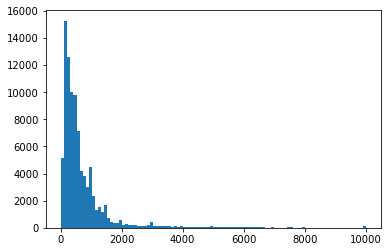

In [33]:
plt.hist(df_train[COL_LOAN_AMOUNT], bins=100)
plt.show()

#### 融資内容
 - 161種類のカテゴリ値
 - 単純なラベルエンコードにしては数が多い？
 - うまくクラスタリングなどができればいい？

In [34]:
pd.DataFrame(df_train[COL_ACTIVITY_NAME].value_counts())

,ACTIVITY_NAME
Farming,11631
Personal Housing Expenses,7993
General Store,7504
Food Production/Sales,4174
Pigs,3790
...,...
Bicycle Sales,3
Patchwork,3
Musical Instruments,3
Utilities,3


In [36]:
pd.DataFrame(df_test[COL_ACTIVITY_NAME].value_counts())

,ACTIVITY_NAME
Farming,13626
General Store,10318
Pigs,6129
Personal Housing Expenses,4703
Food Production/Sales,4304
...,...
Bookbinding,2
Energy,2
Balut-Making,2
Utilities,1


#### 融資内容カテゴリ
 - 15種類のカテゴリ値
 - ターゲットエンコーディング、ラベルエンコーディング、フリークエンシーエンコーディングなど試す価値がありそう
 - 全て1単語のため、分散表現もする価値あり？

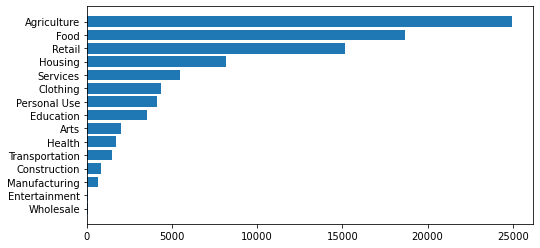

In [48]:
tmp = pd.DataFrame(df_train[COL_SECTOR_NAME].value_counts()).sort_values(by=COL_SECTOR_NAME, ascending=True)
plt.figure(figsize=(8, 4))
plt.barh(tmp.index, tmp['SECTOR_NAME'])
plt.show()

In [37]:
pd.DataFrame(df_train[COL_SECTOR_NAME].value_counts())

,SECTOR_NAME
Agriculture,24965
Food,18701
Retail,15155
Housing,8185
Services,5491
Clothing,4372
Personal Use,4124
Education,3533
Arts,1977
Health,1708


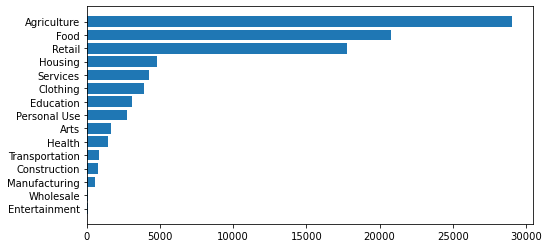

In [49]:
tmp = pd.DataFrame(df_test[COL_SECTOR_NAME].value_counts()).sort_values(by=COL_SECTOR_NAME, ascending=True)
plt.figure(figsize=(8, 4))
plt.barh(tmp.index, tmp['SECTOR_NAME'])
plt.show()

In [50]:
pd.DataFrame(df_test[COL_SECTOR_NAME].value_counts())

,SECTOR_NAME
Agriculture,29058
Food,20790
Retail,17756
Housing,4816
Services,4255
Clothing,3924
Education,3099
Personal Use,2746
Arts,1664
Health,1435


In [51]:
df_train.groupby(COL_SECTOR_NAME).agg({COL_LOAN_AMOUNT: ['median', 'mean']})

LOAN_AMOUNT             
                    median         mean
SECTOR_NAME                            
Agriculture          500.0   668.448828
Arts                 500.0  1007.637835
Clothing             575.0  1092.978042
Construction         600.0   931.558363
Education            575.0   774.752335
Entertainment        725.0  1728.409091
Food                 475.0   855.807176
Health               575.0   788.041569
Housing              200.0   414.722053
Manufacturing        550.0   751.488095
Personal Use         150.0   248.817895
Retail               450.0   789.919169
Services             525.0   924.148607
Transportation       500.0   610.587248
Wholesale            675.0  1620.238095

#### 融資の具体的な使い道
 - 融資内容に比べると短い文章
 - 基本【to】から始まっているが、そうでない文章もある
 - toを前処理で無くした方が良さそう
 - tf-idfやLDAによるトピック分類など特徴量を作る価値がある列

In [52]:
for i in range(5):
    print('='*100)
    print(df_train[COL_LOAN_USE][i])

to purchase  materials like nipa palm, bamboo stick and sibit  (for binding)
to buy two hair clippers, a new barber chair, and other supplies to improve his business.
to purchase sacks of fertilizers to care for and maintain the coffee.
to pay for fuel, tires and change oil for his tricycle.
to purchase hybrid seeds and fertilizer to improve harvests of maize\t\t\t\t\t\t\t


#### 国コード
 - 61種類のカテゴリ値
 - ラベルエンコーディングするには数が多い？
 - うまくクラスタリングできれば特徴量が得られそう

In [53]:
pd.DataFrame(df_train[COL_COUNTRY_CODE].value_counts())

,COUNTRY_CODE
PH,21265
KE,12510
UG,5551
CO,4758
SV,4100
...,...
PA,28
PR,16
LS,11
IL,10


In [54]:
pd.DataFrame(df_test[COL_COUNTRY_CODE].value_counts())

,COUNTRY_CODE
PH,28185
KE,12444
TJ,4388
EC,3818
UG,3088
...,...
PA,37
PR,24
LS,13
IL,11


#### 国名
 - 61種類のカテゴリ値
 - 国コードと完全に対応づけられている
 - 国コードとどちらか一方を使えばよい

In [55]:
pd.DataFrame(df_train[COL_COUNTRY_NAME].value_counts())

,COUNTRY_NAME
Philippines,21265
Kenya,12510
Uganda,5551
Colombia,4758
El Salvador,4100
...,...
Panama,28
Puerto Rico,16
Lesotho,11
Israel,10


In [56]:
pd.DataFrame(df_test[COL_COUNTRY_NAME].value_counts())

,COUNTRY_NAME
Philippines,28185
Kenya,12444
Tajikistan,4388
Ecuador,3818
Uganda,3088
...,...
Panama,37
Puerto Rico,24
Lesotho,13
Israel,11


#### 街名
 - 欠損値が3,000弱ある(学習データ、テストデータ共に)
 - 地域の治安などの情報が取れれば特徴量になりそう
 - 座標を取れば特徴量になる？
 - 欠損している理由がわかれば特徴量になりそう
 - カンマの前後の単語の意味は？

In [59]:
for i in range(5):
    print('='*50)
    print(df_train[COL_TOWN_NAME][i])

Maribojoc, Bohol
Apartadó
Nueva Frontera, Santa Barbara.
Silang, Cavite
Mumias


In [60]:
for i in range(5):
    print('='*50)
    print(df_test[COL_TOWN_NAME][i])

Cauayan, Negros Occidental
Guihulngan, Negros Oriental
Santa Barbara, Iloilo
Pandeglang
Sogod Cebu


#### 通貨方針
 - 0 or 1の二値
 - 学習データとテストデータで分布が異なる
 - バリデーションの際に注意する必要がある？

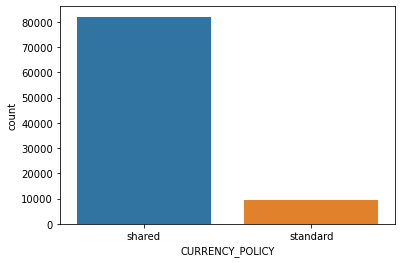

In [74]:
sns.countplot(df_train[COL_CURRENCY_POLICY])
plt.show()

In [73]:
pd.DataFrame(df_train[COL_CURRENCY_POLICY].value_counts())

,CURRENCY_POLICY
shared,82061
standard,9272


In [91]:
df_train.groupby(COL_CURRENCY_POLICY).agg({COL_LOAN_AMOUNT: ['median', 'mean']})

LOAN_AMOUNT             
                     median         mean
CURRENCY_POLICY                         
shared                425.0   702.923130
standard              600.0  1049.921808

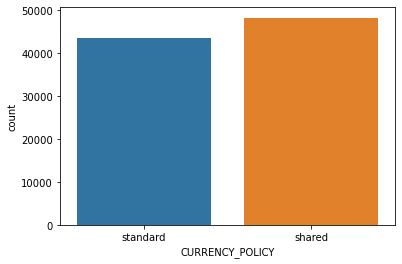

In [75]:
sns.countplot(df_test[COL_CURRENCY_POLICY])
plt.show()

In [76]:
pd.DataFrame(df_test[COL_CURRENCY_POLICY].value_counts())

,CURRENCY_POLICY
shared,48261
standard,43561


#### 通貨交換レート
 - 0 or 1の二値
 - 学習データとテストデータで分布が異なる
 - バリデーションに注意する必要あり？

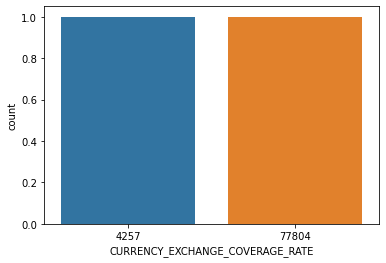

In [68]:
sns.countplot(df_train[COL_CURRENCY_EXCHANGE_COVERAGE_RATE].value_counts())
plt.show()

In [66]:
pd.DataFrame(df_train[COL_CURRENCY_EXCHANGE_COVERAGE_RATE].value_counts())

,CURRENCY_EXCHANGE_COVERAGE_RATE
0.1,77804
0.0,4257


In [90]:
df_train.groupby(COL_CURRENCY_EXCHANGE_COVERAGE_RATE).agg({COL_LOAN_AMOUNT: ['median', 'mean']})

LOAN_AMOUNT            
                                     median        mean
CURRENCY_EXCHANGE_COVERAGE_RATE                        
0.0                                   500.0  780.508574
0.1                                   425.0  698.678089

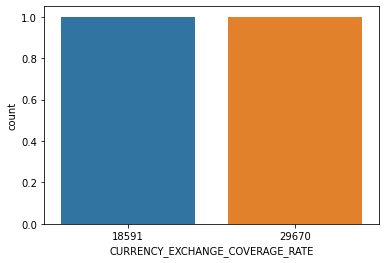

In [69]:
sns.countplot(df_test[COL_CURRENCY_EXCHANGE_COVERAGE_RATE].value_counts())
plt.show()

In [70]:
pd.DataFrame(df_test[COL_CURRENCY_EXCHANGE_COVERAGE_RATE].value_counts())

,CURRENCY_EXCHANGE_COVERAGE_RATE
0.0,29670
0.1,18591


#### 通貨種
 - 51種類のカテゴリ値
 - ラベルエンコーディングするには数が多い？
 - うまくクラスタリングできれば特徴量が得られそう

In [71]:
pd.DataFrame(df_train[COL_CURRENCY].value_counts())

,CURRENCY
PHP,21265
KES,12510
USD,11331
UGX,5551
COP,4758
TJS,3648
KHR,2768
XOF,2548
INR,2123
VND,1774


In [72]:
pd.DataFrame(df_test[COL_CURRENCY].value_counts())

,CURRENCY
PHP,28185
KES,12444
USD,12098
TJS,4386
XOF,3429
UGX,3088
MGA,2664
KHR,2511
COP,1965
PYG,1798


#### タグ
 - 欠損値が多い
 - 削除していい？

In [77]:
for i in range(5):
    print('='*50)
    print(df_train[COL_TAGS][i])

#Elderly
user_favorite, user_favorite
nan
user_favorite
#Eco-friendly, #Sustainable Ag, #Parent, #Elderly, #Vegan, #Repeat Borrower, #Technology, #Woman-Owned Business


In [78]:
for i in range(5):
    print('='*50)
    print(df_test[COL_TAGS][i])

nan
#Animals, #Repeat Borrower, #Schooling, #Woman-Owned Business, #Parent
#Parent, #Single Parent, #Woman-Owned Business
#Woman-Owned Business, #Schooling, #Elderly, #Parent
nan


#### 返済間隔
 - 3種類のカテゴリ値
 - 学習データとテストデータで分布が似ている
 - ターゲットエンコーディング、ラベルエンコーディング、フリークエンシーエンコーディングなど試す価値がありそう

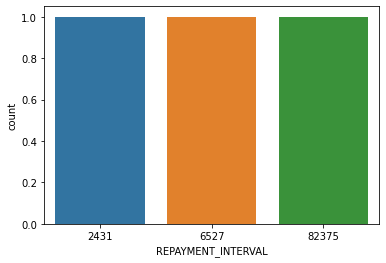

In [79]:
sns.countplot(df_train[COL_REPAYMENT_INTERVAL].value_counts())
plt.show()

In [82]:
pd.DataFrame(df_train[COL_REPAYMENT_INTERVAL].value_counts())

,REPAYMENT_INTERVAL
monthly,82375
bullet,6527
irregular,2431


In [89]:
df_train.groupby(COL_REPAYMENT_INTERVAL).agg({COL_LOAN_AMOUNT: ['median', 'mean']})

LOAN_AMOUNT             
                        median         mean
REPAYMENT_INTERVAL                         
bullet                   500.0   827.390072
irregular                800.0  1028.784451
monthly                  425.0   722.501973

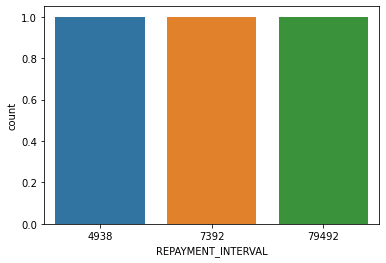

In [80]:
sns.countplot(df_test[COL_REPAYMENT_INTERVAL].value_counts())
plt.show()

In [83]:
pd.DataFrame(df_test[COL_REPAYMENT_INTERVAL].value_counts())

,REPAYMENT_INTERVAL
monthly,79492
bullet,7392
irregular,4938


#### 融資形態
 - 2種類のカテゴリ値
 - 学習データとテストデータで分布が似ている
 - ターゲットエンコーディング、ラベルエンコーディング、フリークエンシーエンコーディングなど試す価値がありそう

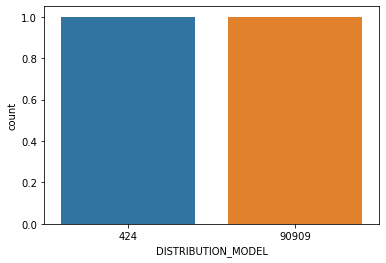

In [84]:
sns.countplot(df_train[COL_DISTRIBUTION_MODEL].value_counts())
plt.show()

In [86]:
pd.DataFrame(df_train[COL_DISTRIBUTION_MODEL].value_counts())

,DISTRIBUTION_MODEL
field_partner,90909
direct,424


In [88]:
df_train.groupby(COL_DISTRIBUTION_MODEL).agg({COL_LOAN_AMOUNT: ['median', 'mean']})

LOAN_AMOUNT             
                        median         mean
DISTRIBUTION_MODEL                         
direct                  5000.0  5673.349057
field_partner            450.0   715.132165

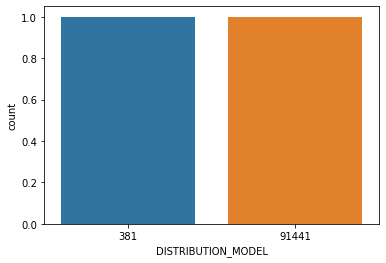

In [85]:
sns.countplot(df_test[COL_DISTRIBUTION_MODEL].value_counts())
plt.show()

In [87]:
pd.DataFrame(df_test[COL_DISTRIBUTION_MODEL].value_counts())

,DISTRIBUTION_MODEL
field_partner,91441
direct,381
